<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

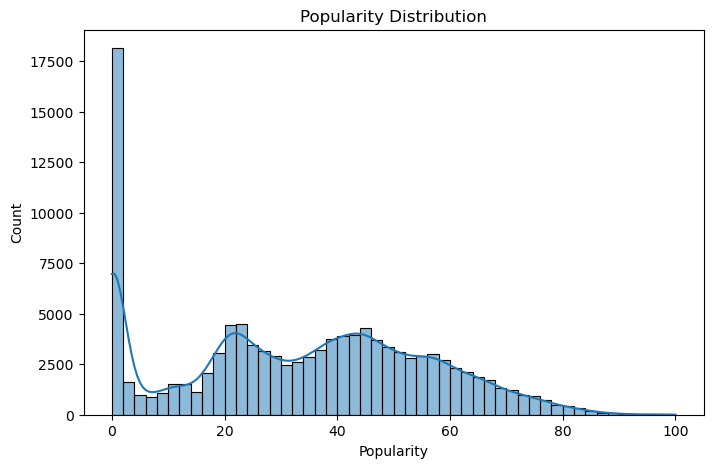

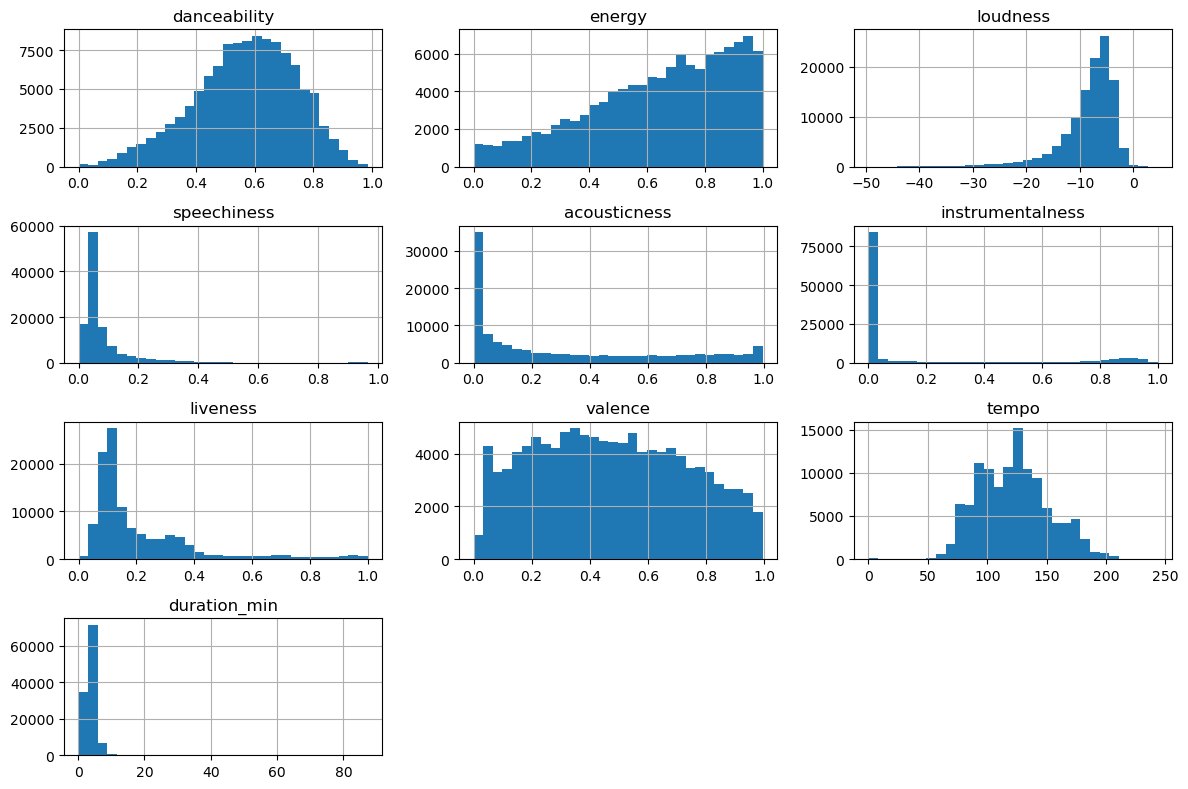

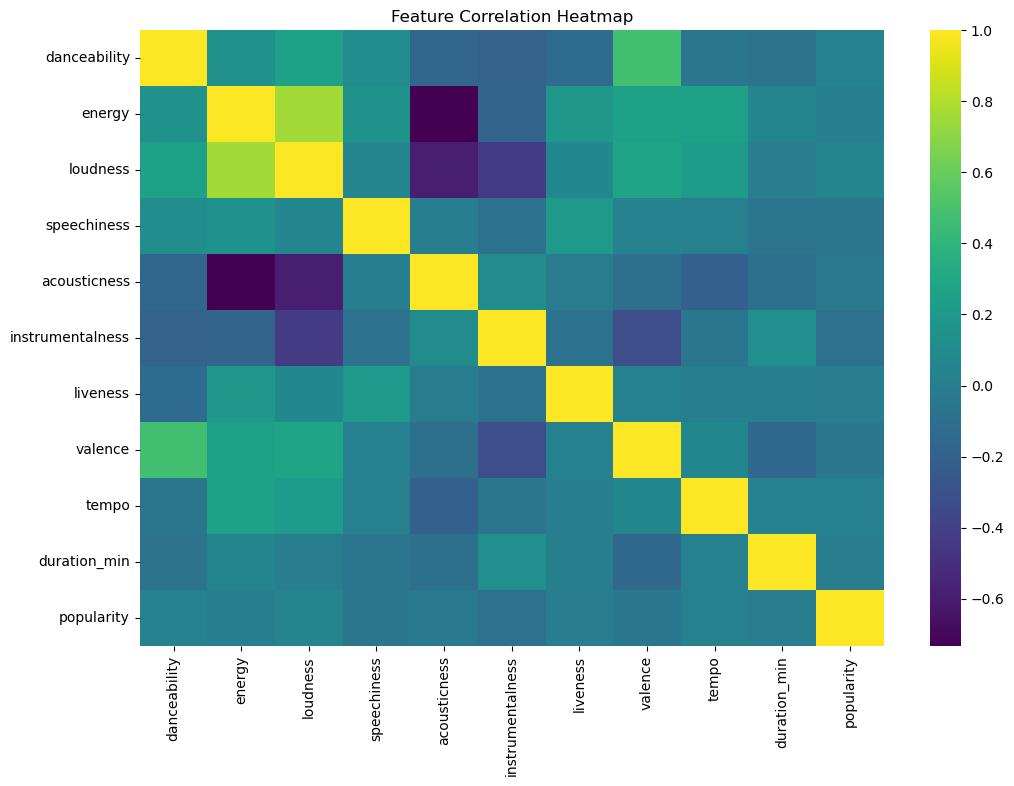

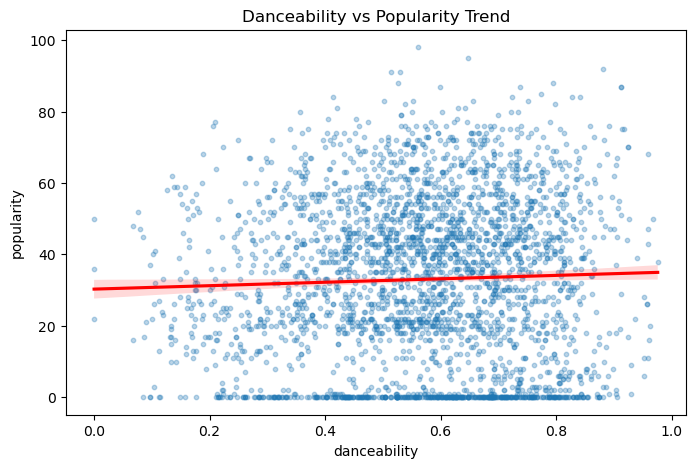

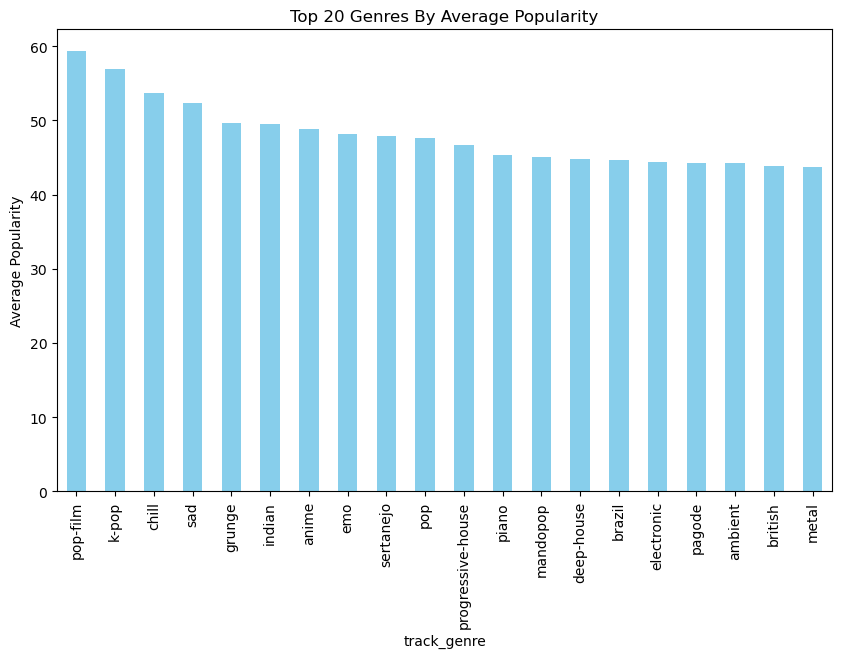

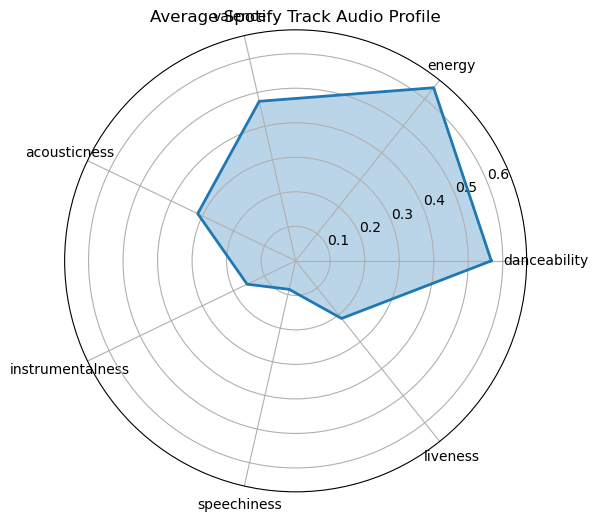

MAE: 18.423989527806697
MSE: 486.3574922382273
R2: 0.019617391163564757


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("spotify.csv")
df.head()

# Getting information about our dataset for some analysis and editing
df.info() #column names, data types, define null or non-nulls
df.describe() #mean, min, max , etc.
df.isnull().sum()  #which columns contain nulls
df.shape   # number of columns and rows
 
#Data cleaning 
df.drop(columns=["Unnamed: 0"], inplace=True)  # this is absolutely unnecessary, we can remove this column for clean data
df.dropna(subset=["artists", "album_name", "track_name"], inplace=True)  #remove null values, bc they are very very small data, we can easily ignore them.
df["duration_min"] = df["duration_ms"] / 60000  #ms is not useful to visualize, converting second looks handsome :)

df.info()
df.head()   # fast check for seeing updates results.

#Visualising process (EDA)
plt.figure(figsize=(8,5))
sns.histplot(df['popularity'], kde=True, bins=50)
plt.title("Popularity Distribution")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()      #This will show us which popularity range is more widespread.

#Audio features histogram
numeric_cols = ['danceability','energy','loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo','duration_min']

df[numeric_cols].hist(figsize=(12,8), bins=30)
plt.tight_layout()
plt.show()

#Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols+['popularity']].corr(), annot=False, cmap='viridis')
plt.title("Feature Correlation Heatmap")
plt.show()     # We can understand which characteristics are most associated with popularity.


plt.figure(figsize=(8,5))
sns.regplot(data=df.sample(3000), x='danceability', y='popularity', scatter_kws={'s':10, 'alpha':0.3}, line_kws={"color":"red"})
plt.title("Danceability vs Popularity Trend")
plt.show()   #F.ex: Are more danceable tracks more popular?

#Top genres
genre_pop = df.groupby('track_genre')['popularity'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
genre_pop.plot(kind='bar', color='skyblue')
plt.title("Top 20 Genres By Average Popularity")
plt.ylabel("Average Popularity")
plt.show()



# Radar chart (the most interesting statistic plot for our dataset)

cols = ['danceability','energy','valence','acousticness','instrumentalness','speechiness','liveness']
mean_vals = df[cols].mean().values

angles=np.linspace(0, 2*np.pi, len(cols), endpoint=False)
mean_vals=np.concatenate((mean_vals,[mean_vals[0]]))
angles=np.concatenate((angles,[angles[0]]))

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111, polar=True)
ax.plot(angles, mean_vals, linewidth=2)    
ax.fill(angles, mean_vals, alpha=0.3)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(cols)
plt.title("Average Spotify Track Audio Profile")
plt.show()

#"The radar chart shows the average profile of audio features. According to the graph, danceability and energy are high in the Spotify dataset, 
#which indicates that the songs are mostly rhythmic and dynamic.
#Acousticness and instrumentalness values are low, which allows us to say that the majority of the songs are vocal and electronic in style.
#Valence is at an average level, meaning that the emotional tone is balanced.
#This graph allows us to see the overall musical character of the dataset at a glance."

# ---------------------------------------------------------------------------------------------------
# Modeling process

#This is for deep analyse and some predictions

# Selecting features and target( setting popularity for this)

features = ['danceability','energy','loudness','speechiness','acousticness',
            'instrumentalness','liveness','valence','tempo','duration_min']

X = df[features]
y = df['popularity']          #preparing data for training

# Train - Test split ( as 80/20 split - it is the best rate for avoid overfitting)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)   # prevent overfitting and enable evaluation 

# fitting Linear Regression model first (acts as baseline) we later improve it with better models such as RandomForest,Xgboost

model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)


# As simple words, it helps us predict popularity rate , which is our main feature, via other features (energy, danceability, ..etc)

#--------------------------------------------------------
#using standart regression metrics to check prediction quality

print("MAE:", mean_absolute_error(y_test, preds))
print("MSE:", mean_squared_error(y_test, preds))
print("R2:", r2_score(y_test, preds))

#Linear Regression gave an R² score of ~0.02, which indicates that linear relationships between audio features and popularity are weak.
#Popularity is influenced by non-linear factors and external variables (social influence, marketing, playlist placement, artist fame, etc.), 
#so more advanced models may be needed for better prediction.


RF MAE: 14.718342586338144
RF R2: 0.2693807070823344


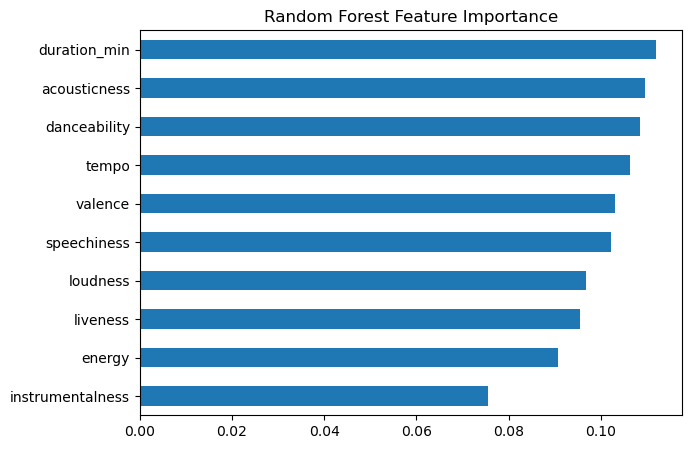

In [4]:
#Advanced modelling for better analyse and predictions.

#Random Forest regression( Better model)

from sklearn.ensemble import RandomForestRegressor

df_sample = df.sample(20000, random_state=42)   # 20k example for avoid slow elapsing
X = df_sample[features]
y = df_sample['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)



rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)

print("RF MAE:", mean_absolute_error(y_test, rf_preds))
print("RF R2:", r2_score(y_test, rf_preds))


#In this output, we notice that our results are betten than Linear regression model, but it is not enough yet

importances = pd.Series(rf.feature_importances_, index=features).sort_values()

importances.plot(kind='barh', figsize=(7,5))
plt.title("Random Forest Feature Importance")
plt.show()    # this chart helps us get information about that which features have more impact on popularity?




In [6]:
%pip install xgboost



   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
    --------------------------------------- 1.0/72.0 MB 3.5 MB/s eta 0:00:21
   - -------------------------------------- 2.1/72.0 MB 4.0 MB/s eta 0:00:18
   - -------------------------------------- 2.6/72.0 MB 4.1 MB/s eta 0:00:17
   - -------------------------------------- 2.9/72.0 MB 3.1 MB/s eta 0:00:23
   -- ------------------------------------- 3.9/72.0 MB 3.5 MB/s eta 0:00:20
   -- ------------------------------------- 5.0/72.0 MB 3.8 MB/s eta 0:00:18
   --- ------------------------------------ 6.3/72.0 MB 4.0 MB/s eta 0:00:17
   ---- ----------------------------------- 7.3/72.0 MB 4.1 MB/s eta 0:00:16
   ---- ----------------------------------- 8.4/72.0 MB 4.2 MB/s eta 0:00:16
   ----- ---------------------------------- 9.4/72.0 MB 4.3 MB/s eta 0:00:15
   ----- ---------------------------------- 10.7/72.0 MB 4.4 MB/s eta 0:00:14
   ------ -

XGB MAE: 15.95226001739502
XGB MSE: 393.9533996582031
XGB R2: 0.1963186264038086


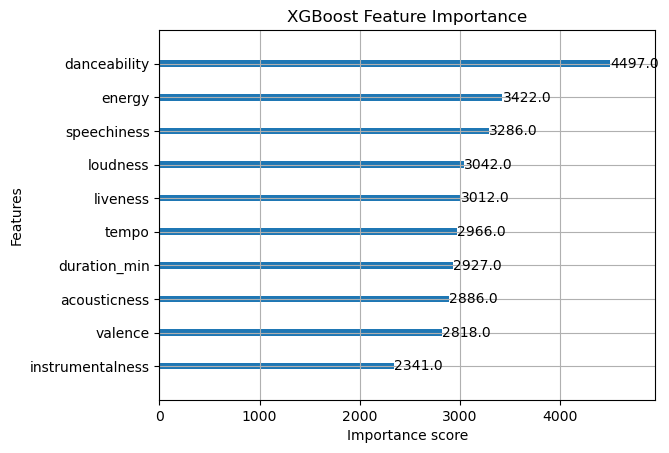

In [7]:
# XGboost method to strength analyse and prediction

from xgboost import XGBRegressor
from xgboost import plot_importance

features = ['danceability','energy','loudness','speechiness','acousticness',
            'instrumentalness','liveness','valence','tempo','duration_min']

X = df_sample[features]      # df_sample: 20k samples for better elapsing
y = df_sample['popularity']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)                                   #creating XGBoost model

xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

# print the results
print("XGB MAE:", mean_absolute_error(y_test, xgb_preds))
print("XGB MSE:", mean_squared_error(y_test, xgb_preds))
print("XGB R2:", r2_score(y_test, xgb_preds))

#feature importance graph
plot_importance(xgb, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

# More advanced boosting models like XGBoost were tested, but Random Forest performed better for this dataset, 
#suggesting that audio features may have more non-linear interactions that Random Forest captured more effectively.





In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

df_sample["popularity_class"] = pd.cut(
    df_sample["popularity"],
    bins=[-1,30,60,100],
    labels=["Low","Medium","High"]
)


X = df_sample[features]
y = df_sample["popularity_class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Regression gave low R², which means predicting the exact popularity score is difficult.
#So I converted the task into classification.
#Now the model predicts whether a song will be Low, Medium or High popularity.
#Accuracy reached around 62%, which is a good result considering that we only use audio features and not social or marketing data.

Accuracy: 0.61925
              precision    recall  f1-score   support

        High       0.77      0.13      0.23       460
         Low       0.64      0.70      0.67      1834
      Medium       0.59      0.67      0.63      1706

    accuracy                           0.62      4000
   macro avg       0.67      0.50      0.51      4000
weighted avg       0.63      0.62      0.60      4000

